# Proyecto minería de datos


El proyecto tendrá como objetivo la clasificación de las emociones. Este análisis se hará con la base de datos de [RAVDESS](https://zenodo.org/record/1188976#.XsyEAmhKhPY). La cual tiene dos tipos de archivos:

Audio: Habla y canto
Video: Habla y canto
Cada uno de estos tiene varios identificadores, los cuales son los siguientes:

*   Modalidad (01 = full-AV, 02 = video-only, 03 = audio-only).

*   Canal de audio (01 = speech, 02 = song).
*   Emoción (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).
*   Intensidad Emocional (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.
*   Declaración (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").
*   Repetición (01 = 1st repetition, 02 = 2nd repetition).
*   Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).


A través de esto, se busca realizar una clasificación de la emoción que encontramos en los archivos. Lo cual será desarrollado por medio de redes neuronales convolucionadas y redes LSTM.

Se tomará como referencia los siguientes proyectos:
Códigos tomados de: https://www.kaggle.com/bhavikjain/cnn-lstm/data
 https://github.com/marcogdepinto/Emotion-Classification-Ravdess/blob/master/EmotionsRecognition.ipynb



# Análisis de sentimientos en audios

El análisis de audio es acerca de analizar y comprender las señales capturadas por dispositivos digitales acerca del análisis y entendimientos de señales de audio. Se realizará un análisis de sentimientos para los audios, utilizando dos métodos diferentes:


*   Analizando directamente el audio a través de librosa y redes convolucionadas y redes LSTM.
*   Analizando el espectrograma del audio como una imagen a través de visión artificial por medio de CNN también. 

Para esto, primero se determinará las librerarías que serán usadadas a lo largo del documento


# Librerias en uso

In [1]:
import librosa
import os, glob, pickle
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
import os #para interactuar con las carpetas y archivos
import pandas as pd
import librosa.display
import tensorflow as tf
import matplotlib.pyplot as plt
import joblib
import keras
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from keras import optimizers
from tensorflow.keras.optimizers import Adam, SGD
from scipy.stats import zscore


Using TensorFlow backend.


# Conectar con drive para leer los datos desde allí 


In [2]:
from google.colab import drive #Conexión con Drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
#Ubicación de los datos 
#PATH = '/content/drive/My Drive/Minería de datos/Proyecto Minería de datos/data/Audio'
PATH = '/content/drive/My Drive/Estadistica/Estadistica/Mineria de datos/Proyecto Minería de datos/data/Audio/'
#PATH = 'G:\Mi unidad\Estadistica\Estadistica\Mineria de datos\Proyecto Minería de datos\data\Audio'

Se determinó a través del camino de la carpeta los archivos que encontramos en el objeto ``dir_list``, el cual tendrá los 2452 archivos de audio. 

In [0]:
dir_list = os.listdir(PATH)
dir_list.sort()


In [19]:
dir_list[1].split('.')[0].split('-')[2]

'01'

Se crean dos objetos ``emotion`` y ``path``, donde en el primero se indicará qué tipo de emoción tenía al hablar donde:
*  01=Neutral
*  02=Calmado
*  03=Feliz
*  04=Triste
*  05=Enojado
*  06=Asustado
*  07=Disgustado
*  08= Sorprendido

Estos fueron extraídos de la **3ra posición** en el nombre del archivo:


In [0]:
emotion = []
mod = []
path = []

for f in dir_list:
  part1 = f.split('.')[0].split('-')[2]
  part2 = f.split('.')[0].split('-')[1]
  path.append(PATH +'/' + f)
  emotion.append(part1)
  mod.append(part2)



In [0]:
# filter rows for year 2002 using  the boolean expression
cam=np.array([path, mod, emotion])
cam=cam.transpose()

data=pd.DataFrame(cam, columns = ['path','mod', 'emotion'])
#


In [0]:
n=data[data['mod']=='02']

In [28]:
n.shape

(1012, 3)

Se puede notar que la cantidad de personas para cada uno de los tipos de emociones no es la misma, donde para la emoción neutral tenemos la mitad que para las emociones. Mientras que para las emociones de disgusto y sorprsa tenemos un poco más de la mitad que para las de calma, felicidad, tristeza, enojado y asustado. 


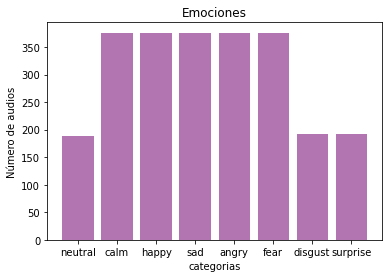

In [0]:

# Make a fake dataset:
height = pd.DataFrame(emotion).groupby(emotion).size()
bars = ('neutral','calm','happy', 'sad', 'angry','fear', 'disgust','surprise')
y_pos = np.arange(len(bars))
 
# Create bars
plt.bar(y_pos, height, color = (0.5,0.1,0.5,0.6))
 
# Add title and axis names
plt.title('Emociones')
plt.xlabel('categorias')
plt.ylabel('Número de audios')

# Create names on the x-axis
plt.xticks(y_pos, bars)


# Show graphic
plt.show()


Ahora, a través de la librería librosa se leerá cada uno de los audios. Para esto se determinará lo siguiente: 
* X: Serie de tiempo del audio
* sample_rate: Frecuencia de muestreo de y
* mfcss: Coeficientes cepstrales de frecuencia de mel (MFCC)

En el procesamiento de señales, el sampling es la reducción de una señal continua en una serie de valores discretos. La **rate** o **sampling frecuency** es el número de muestras tomadas durante un período de tiempo fijo. Una alta frecuencia de muestreo da como resultado una menor pérdida de información pero un mayor gasto computacional, y las bajas frecuencias de muestreo tienen una mayor pérdida de información pero son rápidas y baratas de calcular.

Los coeficientes cepstrales de frecuencia Mel (MFCC) de una señal son un pequeño conjunto de características (generalmente alrededor de 10-20) que describen de manera concisa la forma general de una envoltura espectral. Modela las características de la voz humana.

MFCCs se calculan comúnmente de la siguiente forma:

  1. Separar la señal en pequeños tramos.
  2. A cada tramo aplicarle la Transformada de Fourier discreta y obtener la potencia espectral de la señal.
  3. Aplicar el banco de filtros correspondientes a la Escala Mel al espectro obtenido en el paso anterior y sumar las energías en cada uno de ellos.
  4. Tomar el logaritmo de todas las energías de cada frecuencia mel
  5. Aplicarle la transformada de coseno discreta a estos logaritmos.
  6. Estos valores obtenidos son los coeficientes que buscamos. Aunque opcionalmente se le pueden añadir otros valores como los deltas y/o los delta-deltas.


A través de las características se leen los datos y tendremos las tres características nombradas anteriormente. 


In [0]:
signal = []

# Sample rate (16.0 kHz)
sample_rate = 16000     

# Max pad lenght (3.0 sec)
max_pad_len = 49100

for index,path in enumerate(RAV_df.path):
    X, sample_rate = librosa.load(path
                                  ,duration=3
                                  ,offset=0.5
                                 )
    sample_rate = np.array(sample_rate)
    
    y = zscore(X)
        
    # Padding or truncated signal 
    if len(y) < max_pad_len:    
        y_padded = np.zeros(max_pad_len)
        y_padded[:len(y)] = y
        y = y_padded
    elif len(y) > max_pad_len:
        y = np.asarray(y[:max_pad_len])

    # Add to signal list
    signal.append(y)
    

In [0]:
import time
lst = []

for p in dir_list:
    X, sample_rate = librosa.load(PATH + '/' + p, res_type='kaiser_fast')
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T,axis=0) 
    arr=mfccs, p
    lst.append(arr)




Luego, a partir de nuestros resultados de MFCC, creamos un array con los calores del MFCC y con el path de cada uno de estos archivos

In [0]:
# Creating X and y: zip makes a list of all the first elements, and a list of all the second elements.
X, y1 = zip(*lst)

In [0]:
numbers = [ int(x)-1 for x in emotion ]
y=numbers

Luego, tomaremos como nuestro y la resuesta de 1 hasta 8 para poder realizar la clasificación mediante redes neuronales. Por lo tanto creamos dos array de numpy con esta información.  Como se puede observar el tamaño X como resultado del MFCC será de 2452 x 40 y  nuestra respuesta y, será de 2452.

In [0]:
import numpy as np
X = np.asarray(X)
y = np.asarray(y)


In [0]:
mod=np.asarray(mod)

Como la lectura de los datos se demora mucho tiempo, se guardaran los vectores X y y por medio de la librería joblib y el método dump, de esta forma, luego se podrá leer estos datos en vez de realizar de nuevo el procedimiento de librosa para leer y especificar su MFCC

In [0]:
# Saving joblib files to not load them again with the loop above
X_name = 'X.joblib'
y_name = 'y.joblib'
mod_name='mod.joblib'
save_dir = '/content/drive/My Drive/Estadistica/Estadistica/Mineria de datos/Proyecto Minería de datos/Model_audio'

savedX = joblib.dump(X, os.path.join(save_dir, X_name))
savedy = joblib.dump(y, os.path.join(save_dir, y_name))
savedmod = joblib.dump(mod, os.path.join(save_dir, mod_name))


Por medio del método load de joblib se podrá leer los archivos previamente guardados en la carpeta. 

In [0]:
# Loading saved models
import joblib

X = joblib.load('G:\Mi unidad\Estadistica\Estadistica\Mineria de datos\Proyecto Minería de datos\Model_audio\X.joblib')
y = joblib.load('G:\Mi unidad\Estadistica\Estadistica\Mineria de datos\Proyecto Minería de datos\Model_audio\y.joblib')
mod = joblib.load('G:\Mi unidad\Estadistica\Estadistica\Mineria de datos\Proyecto Minería de datos\Model_audio\mod.joblib')

# Creación de los espectogramas

In [0]:
%matplotlib inline
import os
import pandas as pd
from glob import glob
import numpy as np

from keras import layers
from keras import models
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import Adam
import keras.backend as K
import librosa
import librosa.display
import pylab
import matplotlib.pyplot as plt
from matplotlib import figure
import gc


In [0]:
def create_spectrogram(filename,name):
    plt.interactive(False)
    clip, sample_rate = librosa.load(filename, sr=None)
    fig = plt.figure(figsize=[0.72,0.72])
    ax = fig.add_subplot(111)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    ax.set_frame_on(False)
    S = librosa.feature.melspectrogram(y=clip, sr=sample_rate)
    librosa.display.specshow(librosa.power_to_db(S, ref=np.max))
    filename  = '/content/drive/My Drive/Estadistica/Estadistica/Mineria de datos/Proyecto Minería de datos/data/train/' + name + '.jpg'
    plt.savefig(filename, dpi=400, bbox_inches='tight',pad_inches=0)
    plt.close()    
    fig.clf()
    plt.close(fig)
    plt.close('all')
    del filename,name,clip,sample_rate,fig,ax,S

In [0]:
i=0
for file in path:
    #Define the filename as is, "name" refers to the JPG, and is split off into the number itself. 
    filename,name = file,file.split('/')[-1].split('.')[0]
    create_spectrogram(filename,name)
gc.collect()
#%%memit 
##i=2000
#for file in Data_dir[i:i+2000]:
#    filename,name = file,file.split('/')[-1].split('.')[0]
#    create_spectrogram(filename,name)
#gc.collect()
#%%memit 
#i=4000
#for file in Data_dir[i:]:
#    filename,name = file,file.split('/')[-1].split('.')[0]
#    create_spectrogram(filename,name)
#gc.collect()

6744

In [0]:
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from numpy import expand_dims
from tensorflow.keras.applications.vgg16 import preprocess_input

## Lectura de las imágenes de los espectogramas

In [29]:
PATH = '/content/drive/My Drive/Estadistica/Estadistica/Mineria de datos/Proyecto Minería de datos/data/Audio Img/'
dir_list = os.listdir(PATH)
dir_list.sort()
len(dir_list)

2452

In [0]:
emotion = []
path = []
mod=[]

for f in dir_list:
  part1 = f.split('.')[0].split('-')[2]
  part2 = f.split('.')[0].split('-')[1]
  path.append(PATH +'/' + f)
  emotion.append(part1)
  mod.append(part2)


In [0]:
img=[]
for file in path:
    img1 = load_img(file, target_size=(223, 217))
    img1 = img_to_array(img1)
    # expand dimensions so that it represents a single 'sample'
    img1 = expand_dims(img1, axis=0)
    # prepare the image (e.g. scale pixel values for the vgg)
    img1 = preprocess_input(img1)
    img.append(img1)
  

In [0]:
n=np.array(img)


In [0]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import to_categorical


In [0]:
encoder=LabelEncoder()


In [0]:
# Saving joblib files to not load them again with the loop above
X_name = 'X.joblib'
y_name = 'y.joblib'
mod_name = 'mod.joblib'

save_dir = '/content/drive/My Drive/Estadistica/Estadistica/Mineria de datos/Proyecto Minería de datos/Model_audio_img'

savedX = joblib.dump(n, os.path.join(save_dir, X_name))
savedy = joblib.dump(emotion, os.path.join(save_dir, y_name))
savedmod = joblib.dump(mod, os.path.join(save_dir, mod_name))

In [0]:
# Loading saved models
import joblib

X = joblib.load('/content/drive/My Drive/Estadistica/Estadistica/Mineria de datos/Proyecto Minería de datos/Model_audio_img/X.joblib')
y = joblib.load('/content/drive/My Drive/Estadistica/Estadistica/Mineria de datos/Proyecto Minería de datos/Model_audio_img/y.joblib')
mod = joblib.load('/content/drive/My Drive/Estadistica/Estadistica/Mineria de datos/Proyecto Minería de datos/Model_audio_img/mod.joblib')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


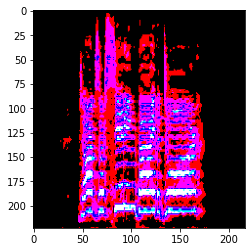

In [0]:
plt.figure()
plt.imshow(X_train[4])
plt.grid(False)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

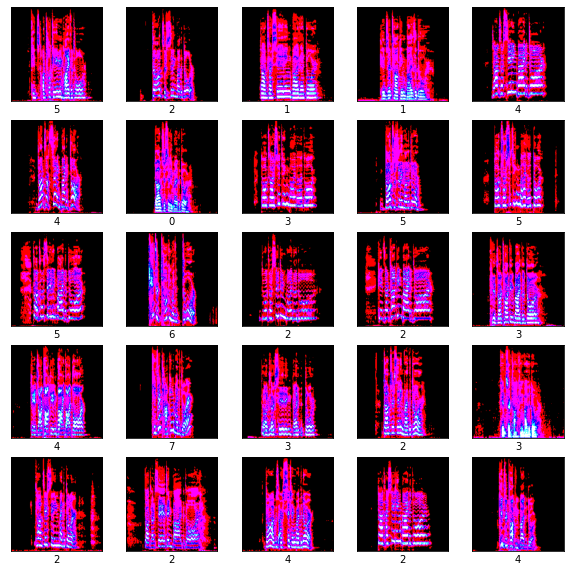

In [0]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[i], cmap=plt.cm.binary)
    plt.xlabel(y_train[i])
plt.show()